## Reddit - analiza

In [1]:
# Opšti paketi
import re
import itertools
import numpy as np
import pandas as pd
import spacy
import string

# NLP alati
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Gensim - za LDA
import gensim
from gensim import corpora, models
import itertools
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from pprint import pprint
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
from gensim.models import LdaModel

# BERTopic
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

# Dimenzionalna redukcija (koristi je BERTopic)
import umap

# Vizualizacija (ako budeš htela kasnije)
import matplotlib.pyplot as plt

# Sklearn - ako bude potrebno za vektore ili dodatnu analizu
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Preuzimanje NLTK resursa (prvi put)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Izbaci warnings
import warnings
warnings.filterwarnings("ignore")

/Users/isidoragataric/miniconda3/envs/isi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/isidoragataric/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/isidoragataric/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/isidoragataric/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Definišem stopwords
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))

In [3]:
# Učitavanje podataka
data = []

with open("full_corpus_with_sentiment_noduplicates.txt", "r", encoding="utf-8") as f:
    for line in f:
        parts = line.strip().split("\t")  # ili .split(",") ili .split("  ")
        if len(parts) == 2:
            data.append(parts)

df = pd.DataFrame(data, columns=["text", "sentiment"])
df

,text,sentiment
0,text,sentiment
1,"after doing all of the above, you are welcome ...",positive
2,"as an act of protest, i have chosen to redact ...",neutral
3,"da, treniraj sebe vec sad da ucis redovno. zna...",negative
4,dont();,neutral
...,...,...
5765,ved godt at denise klarskov sagde at :,neutral
5766,vedi te. io sinceramente quando vedo articoli ...,neutral
5767,"vennov dijagram ljudi koji su sposobni, pametn...",neutral
5768,veoma ima smisla.,neutral


In [4]:
# Čišćenje teksta
# -----------------------------------------------------
# 1. Učitavanje fajla sa kolonama "text" i "sentiment"
# -----------------------------------------------------
df = pd.read_csv("full_corpus_with_sentiment_noduplicates.txt", sep="\t", encoding="utf-8")

# Provera
print("Učitano:", df.shape)
print(df.head())

# -----------------------------------------------------
# 2. Definisanje funkcije za čišćenje teksta
# -----------------------------------------------------
def clean_text(text):
    if pd.isna(text):
        return "", []

    # 1. Uklanjanje ličnih imena (NER)
    doc_ner = nlp(text)
    ents_to_remove = [ent for ent in doc_ner.ents if ent.label_ == 'PERSON']
    intervals = [(ent.start_char, ent.end_char) for ent in ents_to_remove]
    intervals = sorted(intervals, reverse=True)
    for start, end in intervals:
        text = text[:start] + ' ' + text[end:]

    # 2. Standardno čišćenje
    text = text.lower()
    text = re.sub(r"[^a-zA-Zćčžšđ' ]", ' ', text)  # zadrži srpska slova
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 3. Ručno definisane reči za izbacivanje
    custom_remove_words = {
    'a', 'ako', 'l', 'I', 'matematika', 'matematiku', 'm', 'sto', 'što', 'matematike', 'sa', 'pa', 'ide', 'ii', 'ali', 'alibo', 'ališta', 'barem', 'baš', 'bez', 'bi', 'bih', 'bio', 'bili', 'bila', 'bile',
    'bilo', 'bismo', 'biti', 'bog', 'bude', 'budem', 'budemo', 'budete', 'budu', 'budući', 'bila', 'bilo',
    'ce', 'će', 'ćemo', 'ćete', 'ću', 'ćeš', 'čak', 'često', 'da', 'daje', 'dakle', 'dalje', 'dali',
    'danas', 'do', 'akkor', 'gy', 'dobar', 'dobro', 'dok', 'dole', 'dosad', 'dosta', 'drugi', 'druga', 'drugo', 'duž',
    'gde', 'ga', 'hoće', 'hoću', 'hoćeš', 'hoćemo', 'hoćete', 'i', 'iako', 'ih', 'ili', 'imam', 'imamo',
    'ha', 'meg', 'bir', 'yra', 'and', 'bet', 'delete', 'of', 'you', 'bu', 'x', 'nu',
    'bb', 'lol', 'pe', 'have', 'mai', 'by', 'reddit', 'if',
    'mat', 'med', 'perch', 'daha', 'sia', 'matematica', 'aš', 'cosa', 'fare',
    'skal', 'hvis', 'meget', 'nem', 'csak', 'this', 'el', 're', 'st', 'can', 'akkor', 'gy', 'ale', 'tai', 'ma', 'iš', 'nes', 'ai', 'že', 'der', 
    'matematika', 'matematici', 'matematikom', 'matematikos', 'problema', 
    'smer', 'care', 'daugiau', 'post', 'klas', 'cui', 'ch', 'dal', 'uno',
    'so', 'bus', 'nuo', 'molto', 'rs', 'pr', 'comment', 'get', 'gibi',
    'not', 'lt', 'auto', 'labai', 'tak', 'redd', 'volt', 'azt', 'ny', 'vagy', 'anni',
    'so', 'bus', 'nuo', 'molto', 'rs', 'pr', 'comment', 'get', 'gibi', 'fon',
    'fidesz', 'ka', 'tra', 'compose', 'bar','her', 'fa', 'tra', 'ogni', 'tiesiog',
    'mint', 'ezt', 'aki', 'jo', 'meet', 'daug', 'vis', 'ba', 'sem', 'subreddit',
    'ban', 'vagyok', 'tt', 'lo', 'Io', 'fatto', 'edit', 'sta', 'ke', 'cose',
    'imaš', 'treba', 'vise', 'math', 'preview', 'format', 'width', 'webp', 'gal',
    'pjpg', 'es', 'occhi', 'buvo', 'essere', 'nor', 'png', 'možeš', 'imas',
    'cu', 'lehet', 'question', 'dar', 'etf', 'fak', 'apie', 'quindi', 'dei', 'fra', 'eller', 
    'moze', 'prije', 'nek', 'any', 'kur', 'taip', 'nel', 'š', 'message', 'ogs',
    'end', 'tek', 'evo', 'math', 'preview', 'format', 'width', 'webp', 'gal', 'hanno',
    'della', 'kas', 'ovo', 'onda', 'godine', 'godina', 'treba', 'šta', 'neko',
    'ad', 'net', 'solo', 'ama', 'ci', 'al', 'ten', 'har', 'due', 'isto',
    'st', 'this', 'tik', 'af', 'kan', 'par', 'pi', 'www', 'ar', 'anche', 'del', 'come', 'rt', 'gli', 'som', 'y', 'com',
    'til', 'ikke', 'om', 'et', 'den', 'imate', 'ima', 'imaju', 'imao', 'inače', 'ipak', 'itd', 'iz', 'iza', 'između', 'ja', 'je', 'jedan',
    'ki', 'jpeg', 'pjjpg', 'gi', 'cos', 'už', 'dabar', 'hai', 'pdf',
    'jedna', 'jedno', 'jer', 'jesam', 'jesi', 'jeste', 'jesu', 'još', 'ju', 'kad', 'kada', 'kakav', 'kao',
    'kasnije', 'kako', 'kod', 'koja', 'koje', 'koji', 'koju', 'ko', 'kog', 'koga', 'kojeg', 'kojima',
    'koju', 'kroz', 'li', 'malo', 'manje', 'meni', 'me', 'mi', 'moj', 'moja', 'moje', 'moji', 'moram',
    'val', 'that', 'ra', 'ge', 'or', 'mert', 'questo', 'co', 'jau', 'tikrai', 'tutti', 'ho', 'var', 'base',
    'moramo', 'morate', 'mora', 'moraju', 'možda', 'može', 'možemo', 'možete', 'mogu', 'na', 'nad',
    'nakon', 'nam', 'nama', 'nas', 'naš', 'naša', 'naše', 'naši', 'ne', 'neće', 'nećemo', 'nećete', 'neću',
    'nešto', 'nego', 'neka', 'neke', 'neki', 'nekog', 'nekoga', 'nemam', 'nemamo', 'nemate', 'nema',
    'nemaju', 'nemaš', 'nemaš', 'nema', 'nema', 'nešto', 'ni', 'nije', 'nikad', 'nikada', 'niko', 'ništa',
    's', 't', 'n', 'be', 'k', 'r', 'e', 'd', 'b', 'v', 'de', 'in', 'g', 'p',
    'az', 'f', 'egy', 'it', 'sz', 'z', 'https', 'la', 'the', 'c', 'j', 'ez', 'h', 'most', 'ok',
    'un', 'non', 'il', 'una', 've', 'sono', 'le', 'en', 'det', 'du', 'for', 'mere', 'con', 'matematik',
    'di', 'og', 'che', 'at', 'per', 'er', 'ir', 'man', 'hogy', 'niti', 'no', 'novi', 'novo', 'nov', 'o', 'od', 'odmah', 
    'oko', 'on', 'ona', 'oni', 'ono', 'opet', 'matematik', 'https', 'du', 'det', 'most', 'sono', 'io',
    'osim', 'po', 'pod', 'ponekad', 'ponovo', 'posle', 'poslije', 'pre', 'pred', 'prema', 'pri', 'puno',
    'putem', 'sam', 'samo', 'samog', 'samo', 'smo', 'sad', 'sada', 'se', 'sebe', 'sebi', 'si', 'smo',
    'ste', 'su', 'svaki', 'svaka', 'svako', 'sve', 'svi', 'svim', 'svog', 'svoga', 'svoj', 'svoja', 'svoje',
    'ta', 'tada', 'taj', 'tako', 'takođe', 'tačno', 'te', 'tebe', 'tebi', 'ti', 'tim', 'tko', 'to', 'toga',
    'tog', 'toj', 'tom', 'tome', 'tu', 'tvoj', 'tvoja', 'tvoje', 'u', 'uglavnom', 'uz', 'vam', 'vama',
    'vas', 'vaš', 'vaša', 'vaše', 'već', 'veoma', 'vi', 'više', 'vrlo', 'za', 'zar', 'zato', 'zbog', 'ćeš',
    'ću', 'ćemo', 'ćete', 'će', 'što', 'štaviše', 'što', 'želim', 'želimo', 'želite', 'žele', 'želi', 'želiš'
    }

    # 4. Tokenizacija i filtriranje
    tokens = text.split()
    tokens = [word for word in tokens if word not in custom_remove_words]

    # 5. Lemmatizacija
    doc = nlp(' '.join(tokens))
    lemmas = [token.lemma_ for token in doc if token.lemma_.isalpha() and token.lemma_ not in custom_remove_words]

    cleaned_text = ' '.join(lemmas)
    return cleaned_text, lemmas

# -----------------------------------------------------
# 3. Čišćenje celog korpusa
# -----------------------------------------------------
clean_results = df['text'].apply(lambda t: clean_text(str(t)))
df['cleaned_text'] = clean_results.apply(lambda x: x[0])
df['tokens_list'] = clean_results.apply(lambda x: x[1])

# -----------------------------------------------------
# 4. Provera rezultata
# -----------------------------------------------------
print(df[['text', 'cleaned_text']].head())

# Ako želiš da vidiš koliko je sve očišćeno:
print("\nPrimer tokena:\n", df['tokens_list'].iloc[0])

Učitano: (5789, 2)
                                                text sentiment
0     after doing all of the above, you are welco...  positive
1     as an act of protest, i have chosen to reda...   neutral
2     da, treniraj sebe vec sad da ucis redovno. ...  negative
3                                            dont();   neutral
4     faksa ali veruj mi, iskustvo ce ti biti des...   neutral
                                                text  \
0     after doing all of the above, you are welco...   
1     as an act of protest, i have chosen to reda...   
2     da, treniraj sebe vec sad da ucis redovno. ...   
3                                            dont();   
4     faksa ali veruj mi, iskustvo ce ti biti des...   

                                        cleaned_text  
0  after all above welcome join voat voat special...  
1  as an act protest choose redact all ever make ...  
2                                    redovno vremena  
3                                             

In [5]:
# -----------------------------------------------------
# Analiza količine izbačenog teksta
# -----------------------------------------------------

# Izračunaj broj karaktera pre i posle čišćenja
df['original_len'] = df['text'].astype(str).apply(len)
df['cleaned_len'] = df['cleaned_text'].astype(str).apply(len)

# Koliko je karaktera izbačeno
df['removed_chars'] = df['original_len'] - df['cleaned_len']

# Procenat izbačenog teksta po redu
df['removed_pct'] = (df['removed_chars'] / df['original_len']) * 100

# Prosečne vrednosti
avg_removed_chars = df['removed_chars'].mean()
avg_removed_pct = df['removed_pct'].mean()

print("📊 Prosek izbačenog teksta:")
print(f"- Izbačeno prosečno: {avg_removed_chars:.1f} karaktera po tekstu")
print(f"- Prosečno: {avg_removed_pct:.2f}% originalnog teksta")

# Pregled prvih nekoliko primera
print("\n🔹 Primeri:")
print(df[['original_len', 'cleaned_len', 'removed_chars', 'removed_pct']].head())

📊 Prosek izbačenog teksta:
- Izbačeno prosečno: 171.4 karaktera po tekstu
- Prosečno: 48.08% originalnog teksta

🔹 Primeri:
   original_len  cleaned_len  removed_chars  removed_pct
0           579          303            276    47.668394
1           129           65             64    49.612403
2            87           15             72    82.758621
3            10            0             10   100.000000
4            85           51             34    40.000000


In [6]:
# -----------------------------------------------------
# Ukupan broj karaktera pre i posle čišćenja
# -----------------------------------------------------

total_original = df['original_len'].sum()
total_cleaned = df['cleaned_len'].sum()
total_removed = total_original - total_cleaned
total_removed_pct = (total_removed / total_original) * 100

print("\n📈 UKUPNA STATISTIKA ČIŠĆENJA TEKSTA")
print(f"- Ukupan broj karaktera pre čišćenja: {total_original:,}")
print(f"- Ukupan broj karaktera posle čišćenja: {total_cleaned:,}")
print(f"- Ukupno izbačeno: {total_removed:,} karaktera ({total_removed_pct:.2f}%)")


📈 UKUPNA STATISTIKA ČIŠĆENJA TEKSTA
- Ukupan broj karaktera pre čišćenja: 2,067,022
- Ukupan broj karaktera posle čišćenja: 1,075,001
- Ukupno izbačeno: 992,021 karaktera (47.99%)


✅ Unique sentiments: ['positive' 'neutral' 'negative']


2025-10-24 14:27:09,235 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|████████████████████████████████| 177/177 [00:25<00:00,  6.99it/s]
2025-10-24 14:27:34,706 - BERTopic - Embedding - Completed ✓
2025-10-24 14:27:34,707 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-10-24 14:27:55,754 - BERTopic - Dimensionality - Completed ✓
2025-10-24 14:27:55,755 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-24 14:27:56,954 - BERTopic - Cluster - Completed ✓
2025-10-24 14:27:56,958 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-10-24 14:27:57,581 - BERTopic - Representation - Completed ✓


📊 Sažetak tema:
    Topic  Count                                      Name  \
0     -1   3054               -1_problem_nisam_radi_hvala   
1      0    140               0_posao_lavoro_inginer_sunt   
2      1    127                  1_magyar_naučite_hu_orsz   
3      2    123             2_terit_nagy_gyurc_terit rium   
4      3    109  3_programiranje_fakultet_web_računarstvo   
5      4    103           4_facolt_pitanja_avere_consigli   
6      5    100                    5_lesz_szavaz_lenne_mp   
7      6     97       6_youtube_video_watch_youtube watch   
8      7     90             7_matematiky_jsem_jen_algebra   
9      8     74          8_universitete_viet_studijas_att   

                                      Representation  \
0  [problem, nisam, radi, hvala, posao, fakultet,...   
1  [posao, lavoro, inginer, sunt, lei, odnos, fir...   
2  [magyar, naučite, hu, orsz, fel, ben, besz, ht...   
3  [terit, nagy, gyurc, terit rium, rium, prodi, ...   
4  [programiranje, fakultet, we

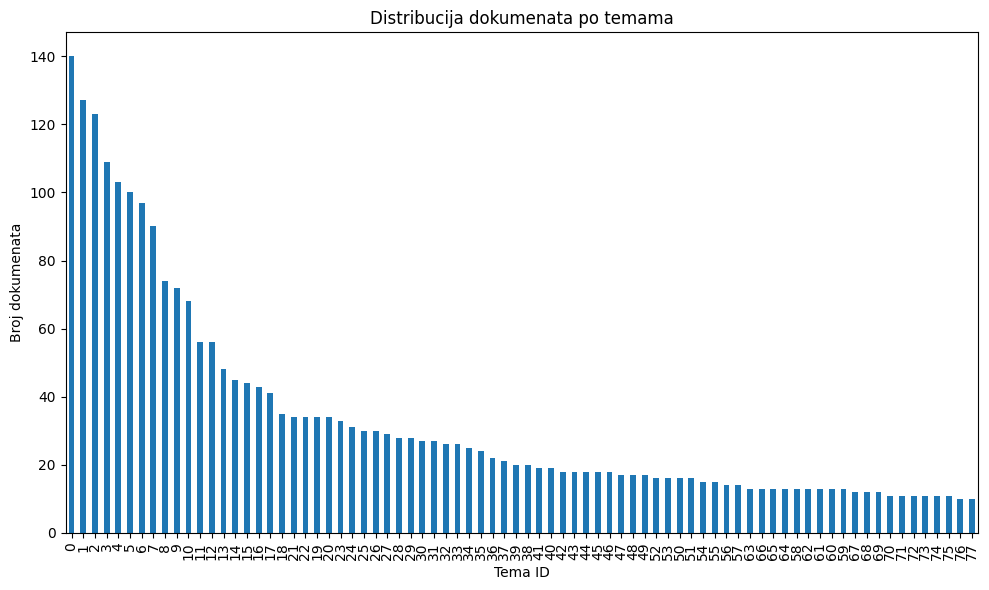

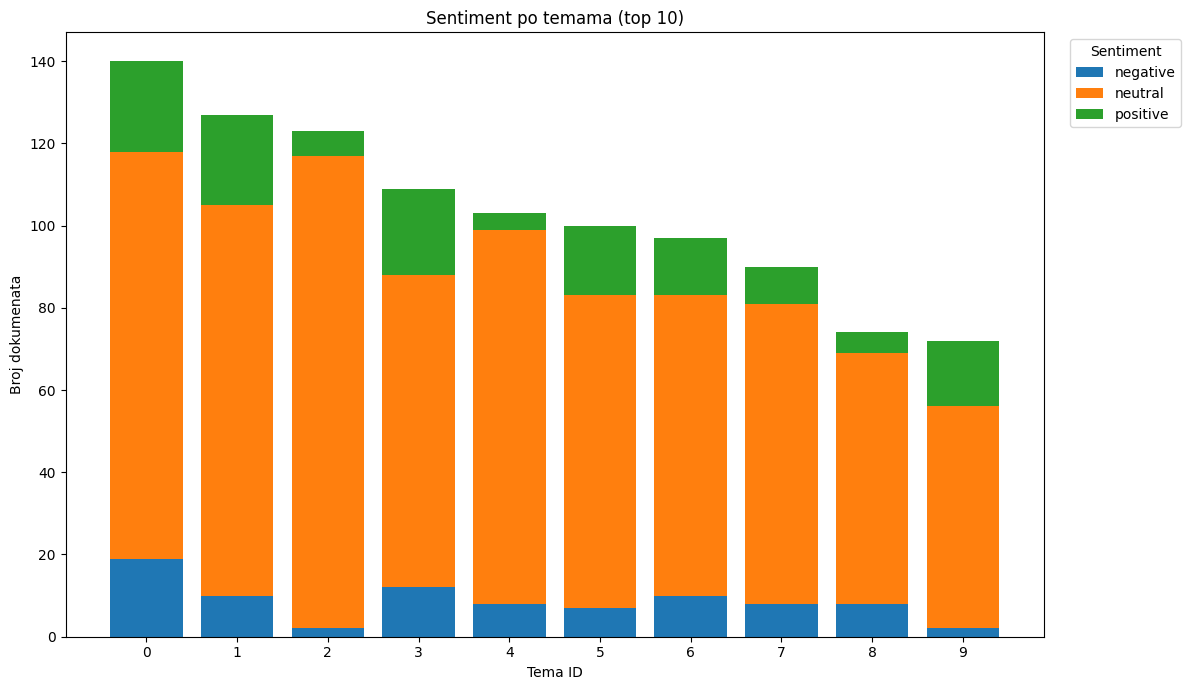

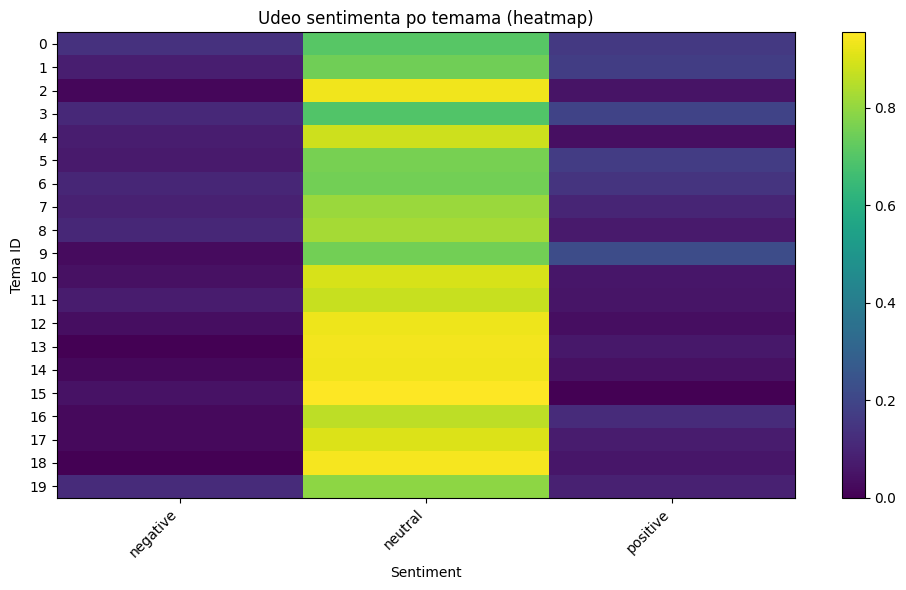

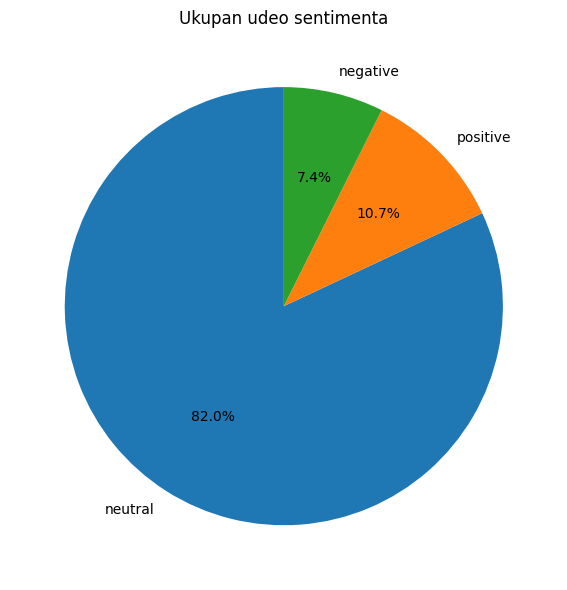

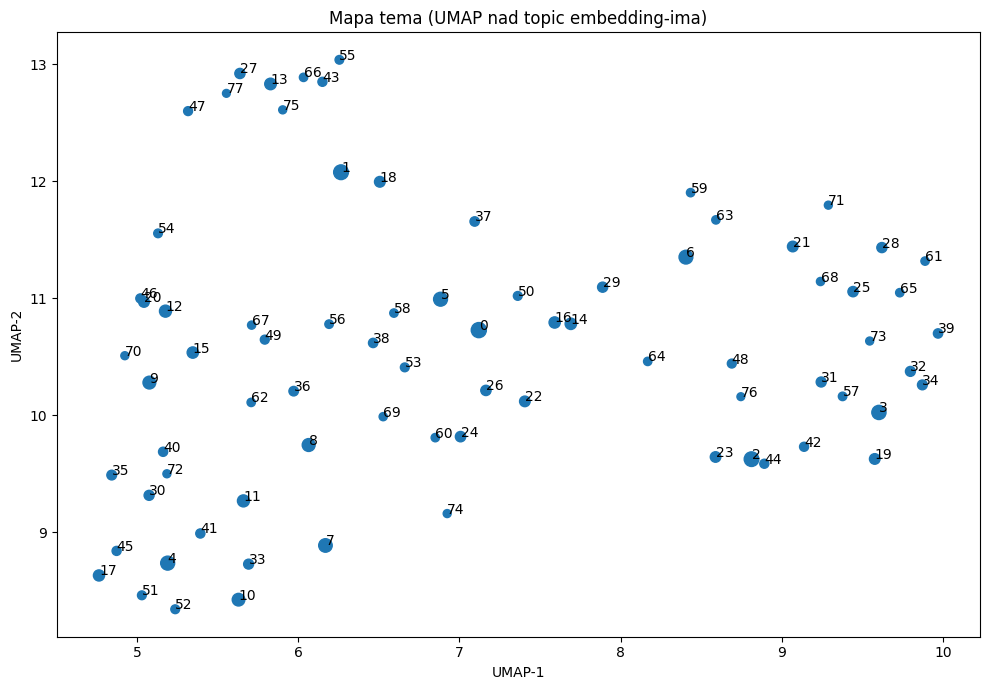


📄 Sačuvan izveštaj: bertopic_outputs/topic_report1.txt

✅ Gotovo! Fajlovi/figure su u folderu 'bertopic_outputs/'.


In [7]:
# ===========================
# BERT
# ===========================
# 1) Imports
# ===========================
import os
import re
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP

# ---------------------------
# 2) Učitavanje i osnovna obrada
# ---------------------------
if "df" not in globals():
    df = pd.read_csv("full_corpus_with_sentiment_noduplicates.txt", sep="\t", encoding="utf-8")

# --- NORMALIZACIJA I ČIŠĆENJE KOLONA ---
df.columns = [c.strip().strip('#"').strip().lower() for c in df.columns]

rename_map = {}
if "text" not in df.columns:
    for cand in ["tekst", "content", "raw_text", '"text"', '\"text\"']:
        if cand in df.columns:
            rename_map[cand] = "text"
            break
if "sentiment" not in df.columns:
    for cand in ["ocena", "label", "target", '"sentiment"', '\"sentiment\"']:
        if cand in df.columns:
            rename_map[cand] = "sentiment"
            break
if rename_map:
    df = df.rename(columns=rename_map)

# --- Ako je prvi red zapravo header, ukloni ga ---
def _looks_like_header(row):
    t = str(row.get("text", "")).strip().lower()
    s = str(row.get("sentiment", "")).strip().lower()
    return (t in {"text", '"text"', '“text”'} or s in {"sentiment", '"sentiment"', '“sentiment”'})

if len(df) and _looks_like_header(df.iloc[0]):
    df = df.iloc[1:].reset_index(drop=True)

# --- Očisti vrednosti sentimenta ---
allowed_map = {
    "positive": "positive", "pozitivan": "positive", "poz": "positive", "pos": "positive", "+": "positive",
    "negative": "negative", "negativan": "negative", "neg": "negative", "-": "negative",
    "neutral": "neutral", "neutralan": "neutral", "neu": "neutral", "0": "neutral",
}

df["sentiment"] = (
    df["sentiment"]
    .astype(str)
    .str.strip()
    .str.strip('\'"“”„”')
    .str.lower()
    .map(lambda x: allowed_map.get(x, x))
)

# --- Zadrži samo validne vrednosti sentimenta ---
valid_vals = {"positive", "negative", "neutral"}
df = df[df["sentiment"].isin(valid_vals)].reset_index(drop=True)

print("✅ Unique sentiments:", df["sentiment"].unique())

# --- Osnovne provere ---
assert "cleaned_text" in df.columns, "Nedostaje kolona 'cleaned_text' — prvo pokreni pipeline za čišćenje."
assert "sentiment" in df.columns, "Nedostaje kolona 'sentiment'."

# Filtriraj prazne
df = df[~df["cleaned_text"].isna() & (df["cleaned_text"].str.strip() != "")]
df = df.reset_index(drop=True)

texts = df["cleaned_text"].tolist()
sentiments = df["sentiment"].tolist()

# ===========================
# 3) Modeli za embeddinge i BERTopic konfiguracija
# ===========================
embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

vectorizer_model = CountVectorizer(
    ngram_range=(1, 3),
    min_df=2,
    stop_words=None,
)

umap_model = UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric="cosine",
    random_state=42
)

topic_model = BERTopic(
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    umap_model=umap_model,
    language="multilingual",
    calculate_probabilities=True,
    verbose=True,
    low_memory=False
)

# ===========================
# 4) Fit
# ===========================
topics, probs = topic_model.fit_transform(texts)
df["topic"] = topics
df["topic_probability"] = [float(p.max()) if p is not None and hasattr(p, "max") else np.nan for p in probs]

topic_info = topic_model.get_topic_info()
print("📊 Sažetak tema:\n", topic_info.head(10))

# ===========================
# 5) Agregacije sentimenta × tema
# ===========================
valid_mask = df["topic"] != -1
df_valid = df[valid_mask].copy()

sentiment_by_topic = (
    df_valid.groupby(["topic", "sentiment"]).size().unstack(fill_value=0)[["negative", "neutral", "positive"]]
)
sentiment_by_topic["total"] = sentiment_by_topic.sum(axis=1)
sentiment_share = sentiment_by_topic.div(sentiment_by_topic["total"], axis=0)

print("\n📈 Distribucija sentimenta po temama (count):\n", sentiment_by_topic.head())
print("\n📈 Udeo sentimenta po temama (share):\n", sentiment_share.head())

# ===========================
# 6) Folder za rezultate
# ===========================
os.makedirs("bertopic_outputs", exist_ok=True)

# ===========================
# 7) Grafici (Matplotlib)
# ===========================
def plot_topic_counts():
    counts = sentiment_by_topic["total"].sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    counts.plot(kind="bar")
    plt.title("Distribucija dokumenata po temama")
    plt.xlabel("Tema ID")
    plt.ylabel("Broj dokumenata")
    plt.tight_layout()
    plt.savefig("bertopic_outputs/topic_counts.png", dpi=160)
    plt.show()

def plot_stacked_sentiment(top_n=10):
    top_topics = sentiment_by_topic.sort_values("total", ascending=False).head(top_n).drop(columns=["total"])
    plt.figure(figsize=(12, 7))
    bottom = np.zeros(len(top_topics))
    for col in top_topics.columns:
        plt.bar(top_topics.index.astype(str), top_topics[col].values, bottom=bottom, label=col)
        bottom += top_topics[col].values
    plt.title(f"Sentiment po temama (top {top_n})")
    plt.xlabel("Tema ID")
    plt.ylabel("Broj dokumenata")
    plt.legend(title="Sentiment", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.savefig("bertopic_outputs/stacked_sentiment_topN.png", dpi=160)
    plt.show()

def plot_heatmap(max_topics=20):
    matr = sentiment_share.drop(columns=["total"]) if "total" in sentiment_share.columns else sentiment_share.copy()
    matr = matr.head(max_topics)
    plt.figure(figsize=(10, 6))
    plt.imshow(matr.values, aspect="auto", interpolation="nearest")
    plt.colorbar()
    plt.title("Udeo sentimenta po temama (heatmap)")
    plt.xlabel("Sentiment")
    plt.ylabel("Tema ID")
    plt.xticks(ticks=range(matr.shape[1]), labels=list(matr.columns), rotation=45, ha="right")
    plt.yticks(ticks=range(matr.shape[0]), labels=matr.index.astype(str))
    plt.tight_layout()
    plt.savefig("bertopic_outputs/heatmap_sentiment_topic.png", dpi=160)
    plt.show()

def plot_sentiment_pie():
    overall = df["sentiment"].value_counts()
    plt.figure(figsize=(6, 6))
    plt.pie(overall.values, labels=overall.index, autopct="%1.1f%%", startangle=90)
    plt.title("Ukupan udeo sentimenta")
    plt.tight_layout()
    plt.savefig("bertopic_outputs/pie_sentiment.png", dpi=160)
    plt.show()

def plot_topic_scatter():
    topic_ids = [tid for tid in set(topics) if tid != -1]
    topic_ids = sorted(topic_ids)
    topic_freq = topic_model.get_topic_info().set_index("Topic")["Count"].to_dict()
    if getattr(topic_model, "topic_embeddings_", None) is not None:
        Te = np.array([topic_model.topic_embeddings_[tid] for tid in topic_ids])
    else:
        doc_emb = topic_model._extract_embeddings(texts, method="document")
        centers = []
        for tid in topic_ids:
            idxs = np.where(df["topic"].values == tid)[0]
            centers.append(doc_emb[idxs].mean(axis=0))
        Te = np.vstack(centers)
    reducer = UMAP(n_neighbors=10, n_components=2, min_dist=0.1, metric="cosine", random_state=42)
    T2 = reducer.fit_transform(Te)
    sizes = [max(20, math.sqrt(topic_freq.get(tid, 1))*10) for tid in topic_ids]
    plt.figure(figsize=(10, 7))
    plt.scatter(T2[:,0], T2[:,1], s=sizes)
    for (x, y, tid) in zip(T2[:,0], T2[:,1], topic_ids):
        plt.text(x, y, str(tid))
    plt.title("Mapa tema (UMAP nad topic embedding-ima)")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.tight_layout()
    plt.savefig("bertopic_outputs/topic_scatter_umap.png", dpi=160)
    plt.show()

plot_topic_counts()
plot_stacked_sentiment(top_n=10)
plot_heatmap(max_topics=20)
plot_sentiment_pie()
plot_topic_scatter()

# ===========================
# 8) Tekstualni izveštaj po temama
# ===========================
def topic_report(n_examples=2, min_len=20):
    info = topic_model.get_topic_info()
    lines = []
    for _, row in info.iterrows():
        tid = int(row["Topic"])
        if tid == -1:
            continue
        words = topic_model.get_topic(tid)
        kw = ", ".join([w for (w, _) in words[:10]]) if words else ""
        lines.append(f"=== Tema {tid} | Count={int(row['Count'])} ===")
        lines.append(f"Top reči: {kw}")
        for s in df["sentiment"].unique():
            subset = df[(df["topic"] == tid) & (df["sentiment"] == s)]
            subset = subset[subset["cleaned_text"].str.len() >= min_len]
            examples = subset.sort_values("topic_probability", ascending=False).head(n_examples)
            if len(examples):
                lines.append(f"  • Primeri ({s}):")
                for _, r in examples.iterrows():
                    snippet = r["text"]
                    snippet = re.sub(r"\s+", " ", str(snippet)).strip()
                    if len(snippet) > 220:
                        snippet = snippet[:220] + "..."
                    lines.append(f"      - {snippet}")
        lines.append("")
    report = "\n".join(lines)
    with open("bertopic_outputs/topic_report1.txt", "w", encoding="utf-8") as f:
        f.write(report)
    print("\n📄 Sačuvan izveštaj: bertopic_outputs/topic_report1.txt")

topic_report(n_examples=3, min_len=15)

# ===========================
# 9) Snimi rezultate
# ===========================
topic_info.to_csv("bertopic_outputs/topic_info1.csv", index=False, encoding="utf-8")
df.to_csv("bertopic_outputs/bertopic_docs_with_topics1.csv", index=False, encoding="utf-8")

print("\n✅ Gotovo! Fajlovi/figure su u folderu 'bertopic_outputs/'.")

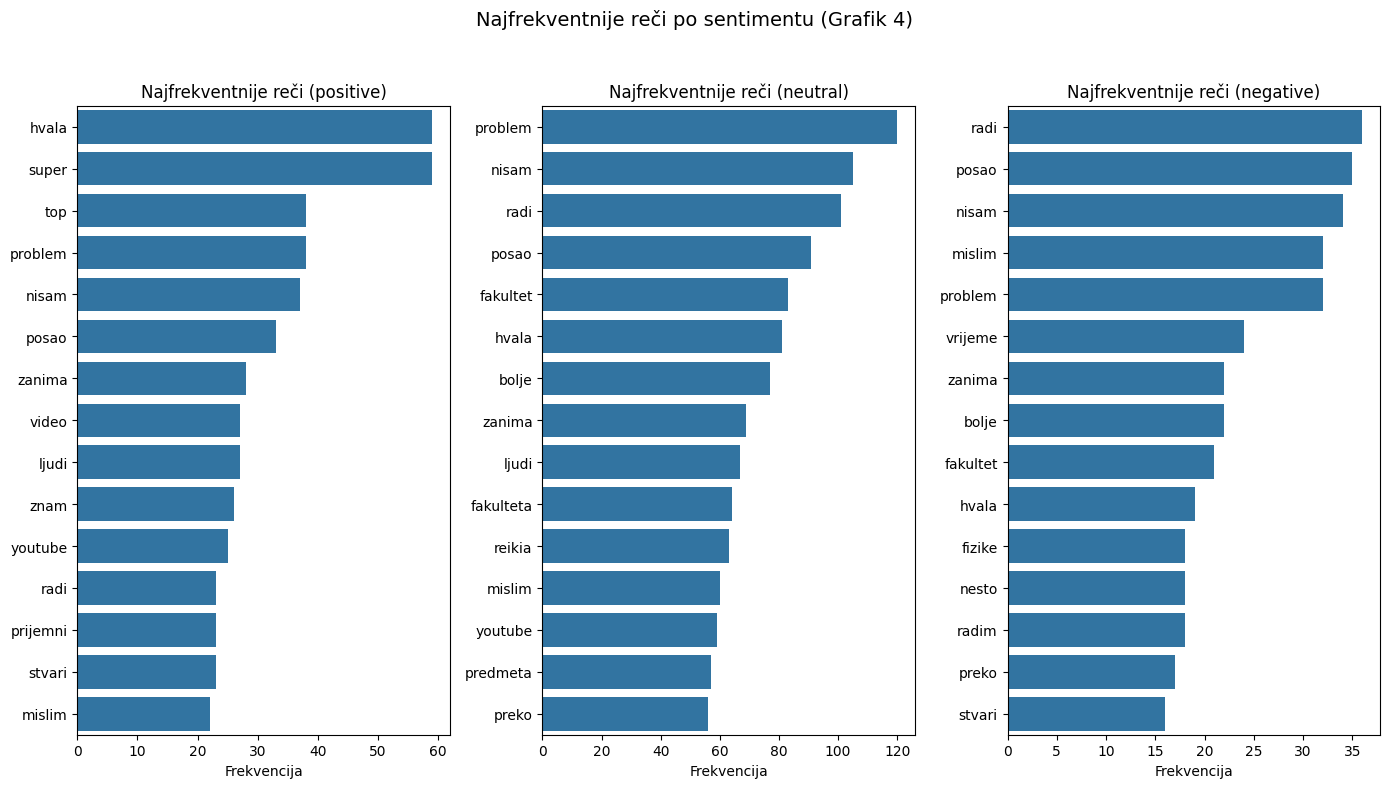

In [8]:
# ===========================
# 7.6 Najfrekventnije reči po sentimentu (Grafik 4)
# ===========================
from collections import Counter
import seaborn as sns

def plot_top_words_by_sentiment(top_n=15):
    plt.figure(figsize=(14, 8))
    sentiments_unique = df["sentiment"].unique()
    
    for i, sent in enumerate(sentiments_unique, 1):
        # Uzmi tekstove za taj sentiment
        texts_sent = df[df["sentiment"] == sent]["cleaned_text"].tolist()
        all_words = " ".join(texts_sent).split()
        counter = Counter(all_words)
        top_words = counter.most_common(top_n)
        
        # Priprema podataka za plot
        words, freqs = zip(*top_words)
        plt.subplot(1, len(sentiments_unique), i)
        sns.barplot(x=list(freqs), y=list(words), orient="h")
        plt.title(f"Najfrekventnije reči ({sent})")
        plt.xlabel("Frekvencija")
        plt.ylabel("")
    
    plt.suptitle("Najfrekventnije reči po sentimentu (Grafik 4)", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig("bertopic_outputs/top_words_by_sentiment.png", dpi=160)
    plt.show()

plot_top_words_by_sentiment(top_n=15)